<a href="https://colab.research.google.com/github/DanielaVL/PrediccionRendimientoAcademico/blob/main/ModelosML_CursoMatematicas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Librerías

In [5]:
#Se importan las bibliotecas necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from mlxtend.plotting import scatterplotmatrix
from mlxtend.plotting import heatmap
from yellowbrick.regressor import residuals_plot

from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold

from sklearn.pipeline import make_pipeline

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import learning_curve

from sklearn.ensemble import AdaBoostRegressor

# Funciones para gráficar

In [6]:
def plot_residuals(yp1, yt1, yp2, yt2, title = "Residuales"):

    '''
    Esta función grafica los residuales para un conjunto de predicciones en los datos
    de entrenamiento y de prueba

    Parameters:
        yp1 (array): Valores predichos del conjunto entrenamiento
        yt1 (array): Valores reales del conjunto entrenamiento
        yp2 (array): Valores predichos del conjunto prueba
        yt2 (array): Valores reales del conjunto prueba
        title (str): Título de la gráfica
    Returns:
        None
    '''
    plt.scatter(
            yp1,
            yp1 - yt1,
            c='steelblue',
            edgecolor='white',
            marker='o',
            s=35,
            alpha=0.9,
            label='Datos entrenamiento')
    plt.scatter(yp2,
                yp2 - yt2,
                c='limegreen',
                edgecolor='white',
                marker='s',
                s=35,
                alpha=0.9,
                label='Datos prueba')
    plt.title(title)
    plt.xlabel('Valores predichos')
    plt.ylabel('Residuales')
    plt.legend(loc='upper left')
    plt.hlines(y=0, xmin=-10, xmax=50, lw=2, color='black')
    plt.xlim([-10, 50])
    plt.tight_layout()
    plt.show()

In [7]:
def plot_learning_curve(regressor, Xtrain, ytrain, cv = 2, scoring = "r2", title = "Curva de aprendizaje"):
    '''
    Esta función grafica la curva de aprendizaje dado un regresor.

    Parameters:
        Xtrain (n-dimensinal array): conjunto entrenamiento
        ytrain (1-D array): característica de salida conjunto de entrenamiento
        cv: valor para la validación cruzada
        scoring (str): Nombre de la métrica de regresión de https://scikit-learn.org/stable/modules/model_evaluation.html
        title: título de la gráfica
    Returns:
        None
    '''
    train_sizes, train_scores, test_scores =\
     learning_curve(estimator=regressor,
     X=Xtrain,
     y=ytrain,
     train_sizes=np.linspace(
     0.1, 1.0, 10),
     cv=cv,
     n_jobs=1,
     scoring = scoring)

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)


    plt.plot(
        train_sizes, train_mean,
        color='blue', marker='o',
        markersize=5, label=f'{scoring} entrenamiento')

    plt.fill_between(train_sizes,
                     train_mean + train_std,
                     train_mean - train_std,
                     alpha=0.15, color='blue')
    plt.plot(train_sizes, test_mean,
             color='green', linestyle='--',
             marker='s', markersize=5,
             label=f'{scoring} validación')

    plt.fill_between(train_sizes,
                     test_mean + test_std,
                     test_mean - test_std,
                     alpha=0.15, color='green')
    plt.title(title)
    plt.grid(True)
    plt.xlabel('Número de muestras de entrenamiento')
    plt.ylabel(scoring)
    plt.legend(loc='lower right')
    plt.ylim([0.0, 1.01])
    plt.show()

# Preparación de datos

## Carga de datos

In [8]:
#Datos del curso
data = pd.read_csv("student-mat.csv", sep=";")
data.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


In [9]:
# Resumen estadístico de las columnas numéricas
data.describe()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
count,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000
mean,16.696203,2.749367,2.521519,1.448101,2.035443,0.334177,3.944304,3.235443,3.108861,1.481013,2.291139,3.554430,5.708861,10.908861,10.713924,10.415190
std,1.276043,1.094735,1.088201,0.697505,0.839240,0.743651,0.896659,0.998862,1.113278,0.890741,1.287897,1.390303,8.003096,3.319195,3.761505,4.581443
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,3.000000,0.000000,0.000000
25%,16.000000,2.000000,2.000000,1.000000,1.000000,0.000000,4.000000,3.000000,2.000000,1.000000,1.000000,3.000000,0.000000,8.000000,9.000000,8.000000
50%,17.000000,3.000000,2.000000,1.000000,2.000000,0.000000,4.000000,3.000000,3.000000,1.000000,2.000000,4.000000,4.000000,11.000000,11.000000,11.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,8.000000,13.000000,13.000000,14.000000
max,22.000000,4.000000,4.000000,4.000000,4.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,75.000000,19.000000,19.000000,20.000000


In [10]:
# Resumen de las estadísticas descriptivas de las columnas categóricas
data.describe(include=['object'])

,school,sex,address,famsize,Pstatus,Mjob,Fjob,reason,guardian,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic
count,395,395,395,395,395,395,395,395,395,395,395,395,395,395,395,395,395
unique,2,2,2,2,2,5,5,4,3,2,2,2,2,2,2,2,2
top,GP,F,U,GT3,T,other,other,course,mother,no,yes,no,yes,yes,yes,yes,no
freq,349,208,307,281,354,141,217,145,273,344,242,214,201,314,375,329,263


In [11]:
# Información sobre la estructura del DataFrame (tipos de datos, cantidad de valores no nulos)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      395 non-null    object
 1   sex         395 non-null    object
 2   age         395 non-null    int64 
 3   address     395 non-null    object
 4   famsize     395 non-null    object
 5   Pstatus     395 non-null    object
 6   Medu        395 non-null    int64 
 7   Fedu        395 non-null    int64 
 8   Mjob        395 non-null    object
 9   Fjob        395 non-null    object
 10  reason      395 non-null    object
 11  guardian    395 non-null    object
 12  traveltime  395 non-null    int64 
 13  studytime   395 non-null    int64 
 14  failures    395 non-null    int64 
 15  schoolsup   395 non-null    object
 16  famsup      395 non-null    object
 17  paid        395 non-null    object
 18  activities  395 non-null    object
 19  nursery     395 non-null    object
 20  higher    

In [12]:
# Creación del DataFrame
df = pd.DataFrame(data)

In [13]:
# Separación de datos categóricos y numéricos
datos_categoricos = df.select_dtypes(include=['object'])
datos_numericos = df.select_dtypes(exclude=['object'])

In [14]:
print("Datos Categóricos:")
print(datos_categoricos)

print("\nDatos Numéricos:")
print(datos_numericos)

Datos Categóricos:
    school sex address famsize Pstatus      Mjob      Fjob  reason guardian  \
0       GP   F       U     GT3       A   at_home   teacher  course   mother   
1       GP   F       U     GT3       T   at_home     other  course   father   
2       GP   F       U     LE3       T   at_home     other   other   mother   
3       GP   F       U     GT3       T    health  services    home   mother   
4       GP   F       U     GT3       T     other     other    home   father   
..     ...  ..     ...     ...     ...       ...       ...     ...      ...   
390     MS   M       U     LE3       A  services  services  course    other   
391     MS   M       U     LE3       T  services  services  course   mother   
392     MS   M       R     GT3       T     other     other  course    other   
393     MS   M       R     LE3       T  services     other  course   mother   
394     MS   M       U     LE3       T     other   at_home  course   father   

    schoolsup famsup paid activi

## Codificación one-hot

In [15]:
# Codificación one-hot a las columnas categóricas del DataFrame
datos_categoricos = pd.get_dummies(datos_categoricos, columns=['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic'])

In [16]:
print("Datos Categóricos:")
print(datos_categoricos)

print("\nDatos Numéricos:")
print(datos_numericos)

Datos Categóricos:
     school_GP  school_MS  sex_F  sex_M  address_R  address_U  famsize_GT3  \
0            1          0      1      0          0          1            1   
1            1          0      1      0          0          1            1   
2            1          0      1      0          0          1            0   
3            1          0      1      0          0          1            1   
4            1          0      1      0          0          1            1   
..         ...        ...    ...    ...        ...        ...          ...   
390          0          1      0      1          0          1            0   
391          0          1      0      1          0          1            0   
392          0          1      0      1          1          0            1   
393          0          1      0      1          1          0            0   
394          0          1      0      1          0          1            0   

     famsize_LE3  Pstatus_A  Pstatus_T  ... 

In [17]:
#  Creación de un nuevo DataFrame que contiene tanto las columnas numéricas originales como las columnas one-hot codificadas
df_ohe = pd.concat([datos_numericos, datos_categoricos], axis = 1)
df_ohe.shape

(395, 59)

In [18]:
df_ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 59 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   age                395 non-null    int64
 1   Medu               395 non-null    int64
 2   Fedu               395 non-null    int64
 3   traveltime         395 non-null    int64
 4   studytime          395 non-null    int64
 5   failures           395 non-null    int64
 6   famrel             395 non-null    int64
 7   freetime           395 non-null    int64
 8   goout              395 non-null    int64
 9   Dalc               395 non-null    int64
 10  Walc               395 non-null    int64
 11  health             395 non-null    int64
 12  absences           395 non-null    int64
 13  G1                 395 non-null    int64
 14  G2                 395 non-null    int64
 15  G3                 395 non-null    int64
 16  school_GP          395 non-null    uint8
 17  school_MS       

## Análisis de variables y exploración de datos

In [19]:
# Se crea un arreglo de nombres de columnas a partir del DataFrame
columns = df_ohe.columns.to_numpy()

In [20]:
len(columns)

59

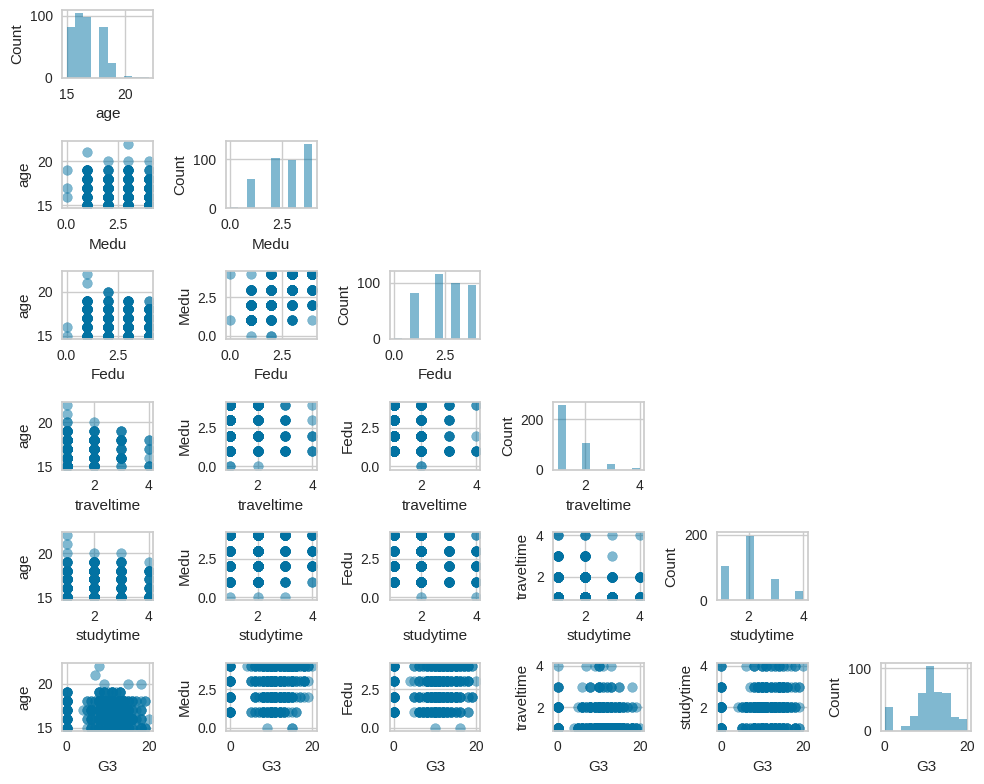

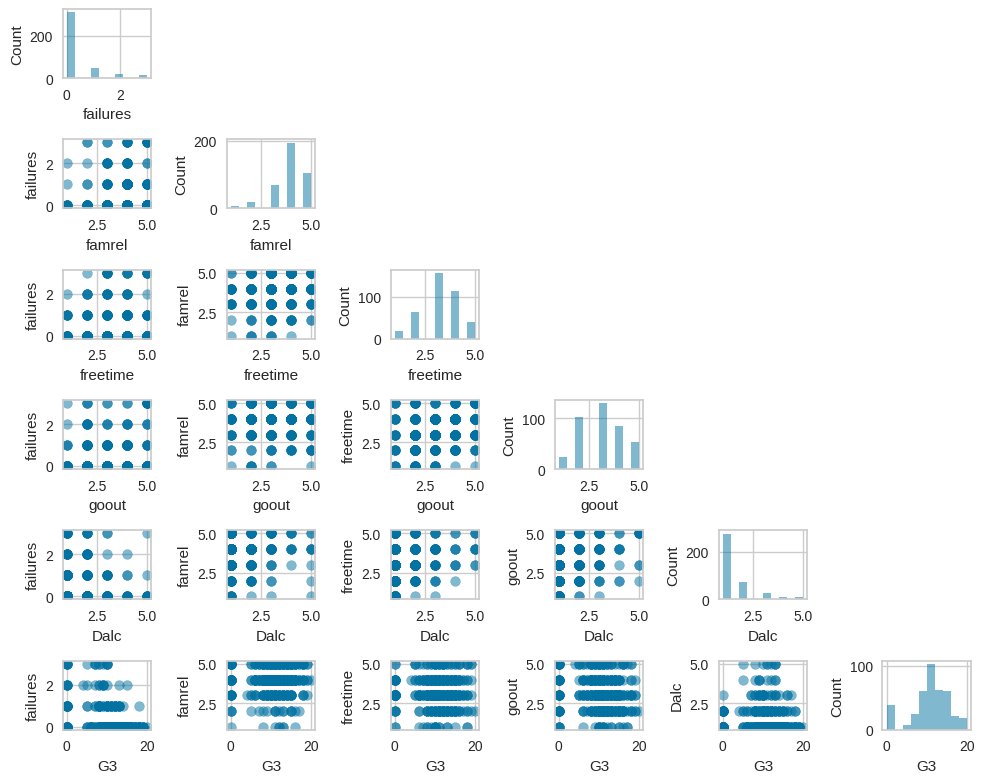

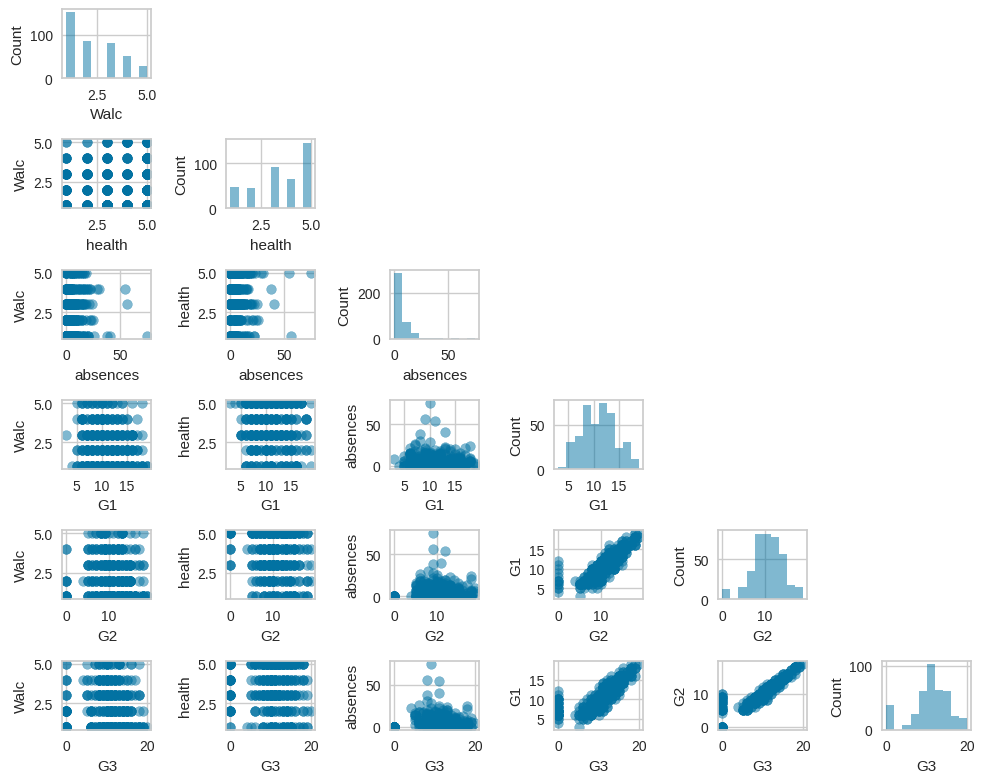

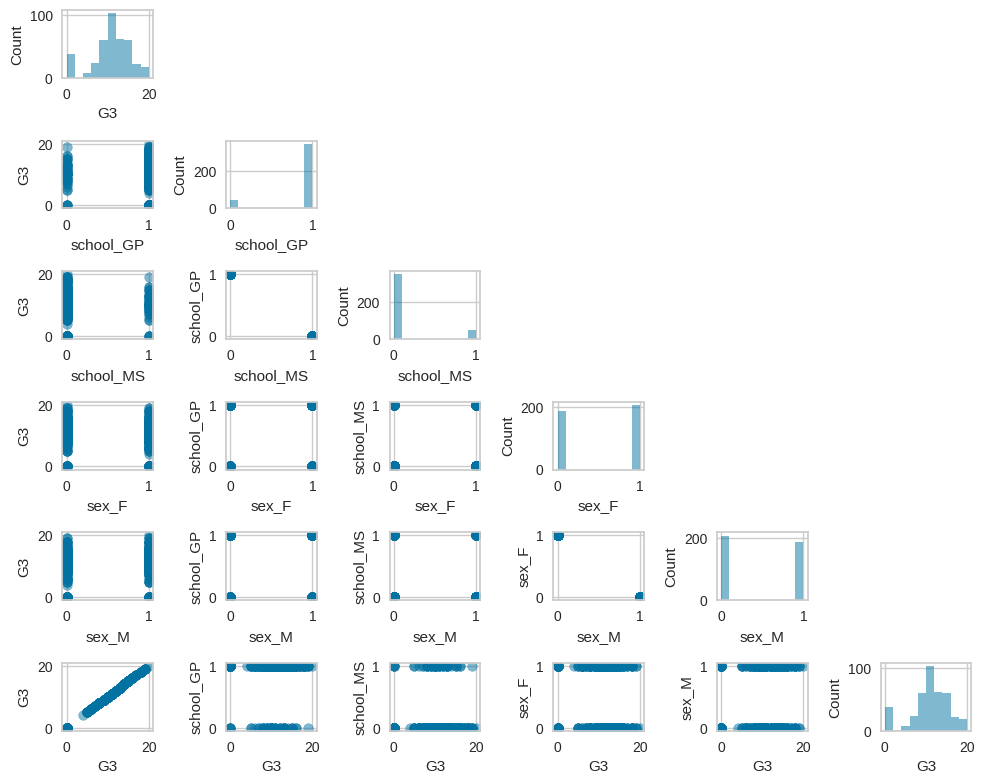

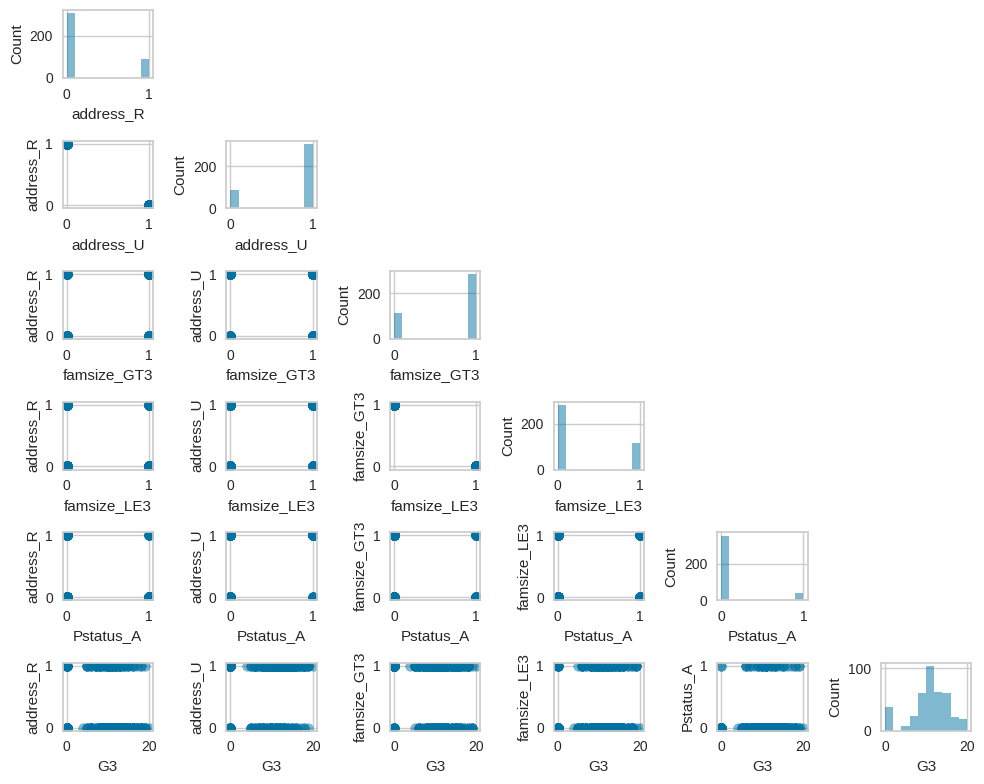

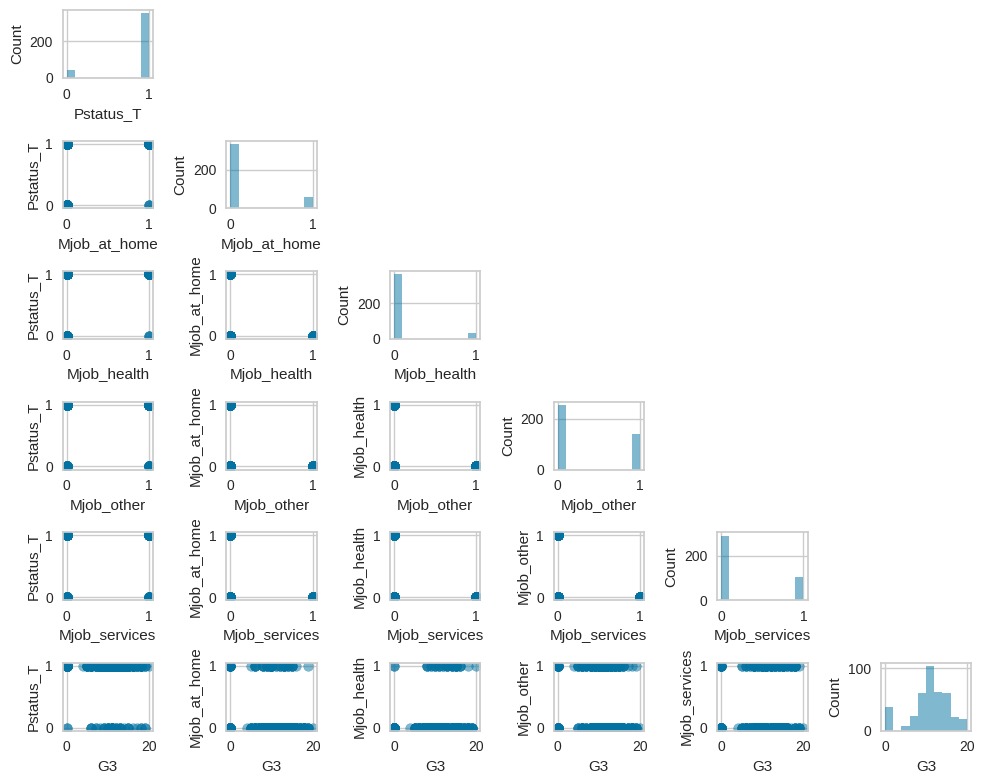

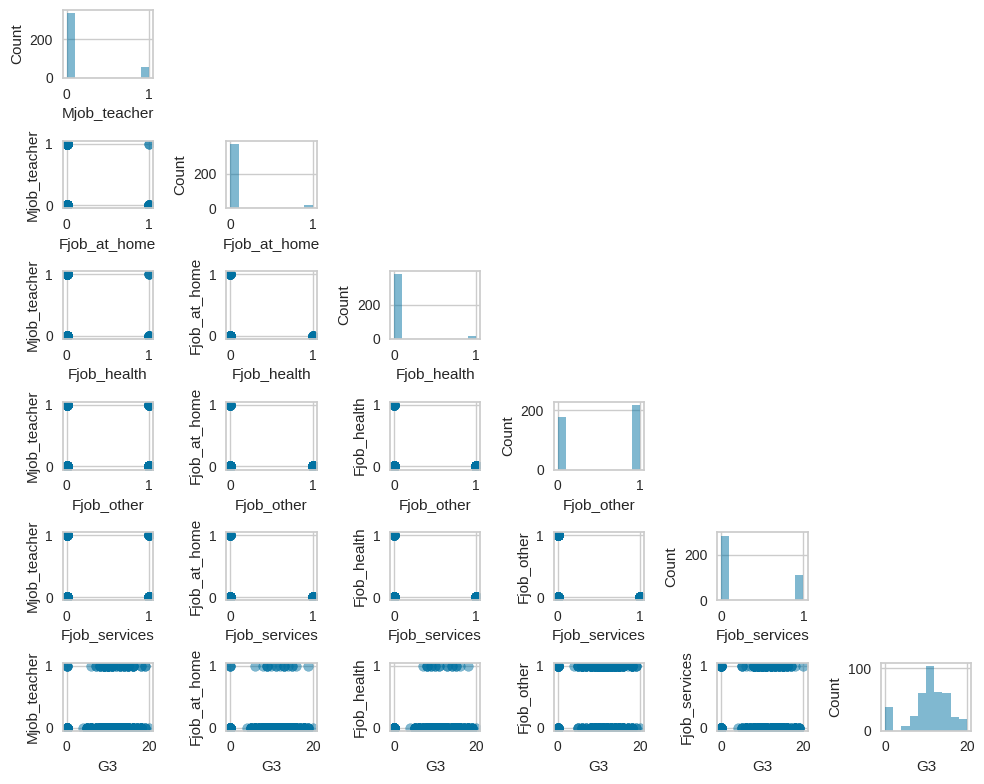

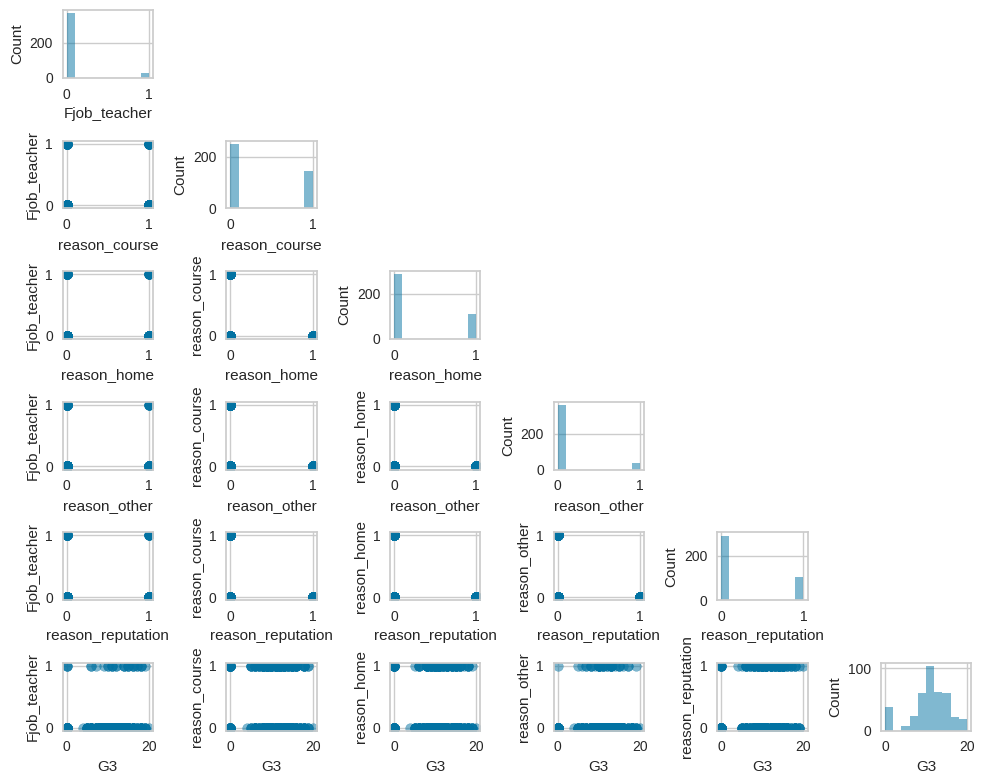

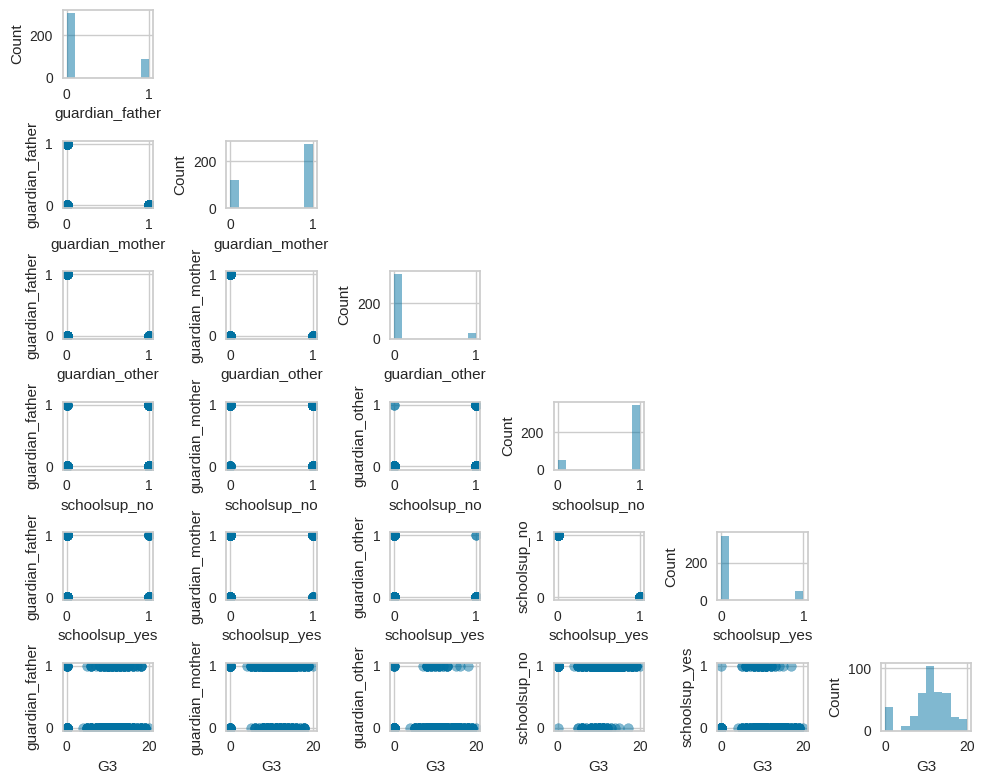

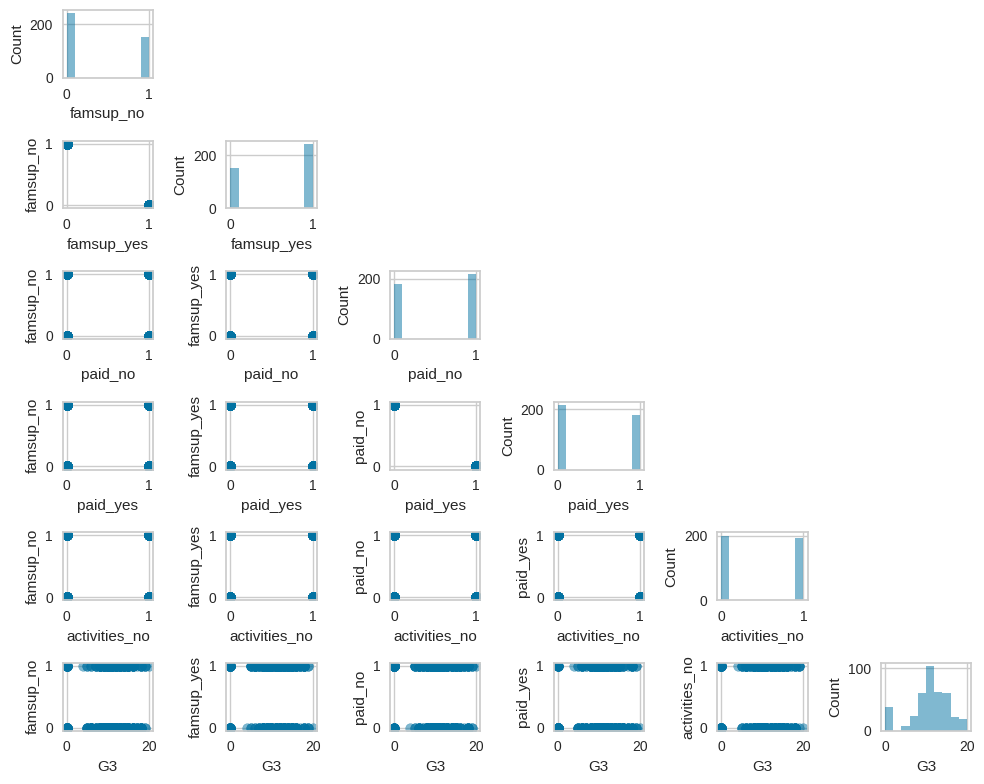

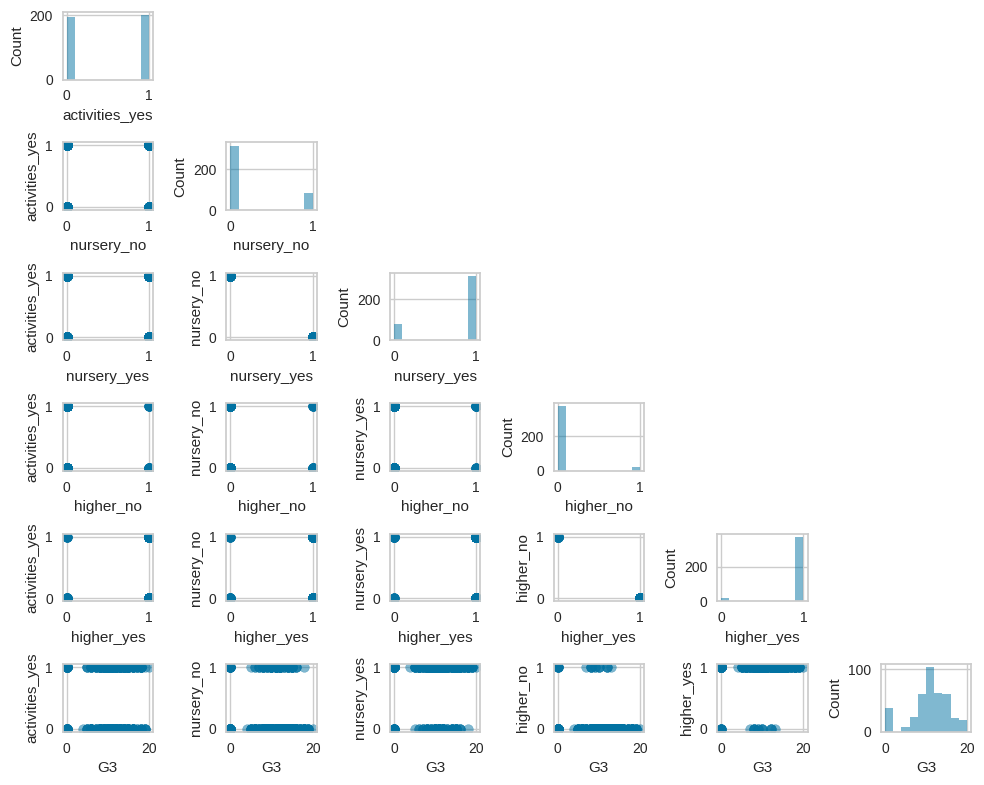

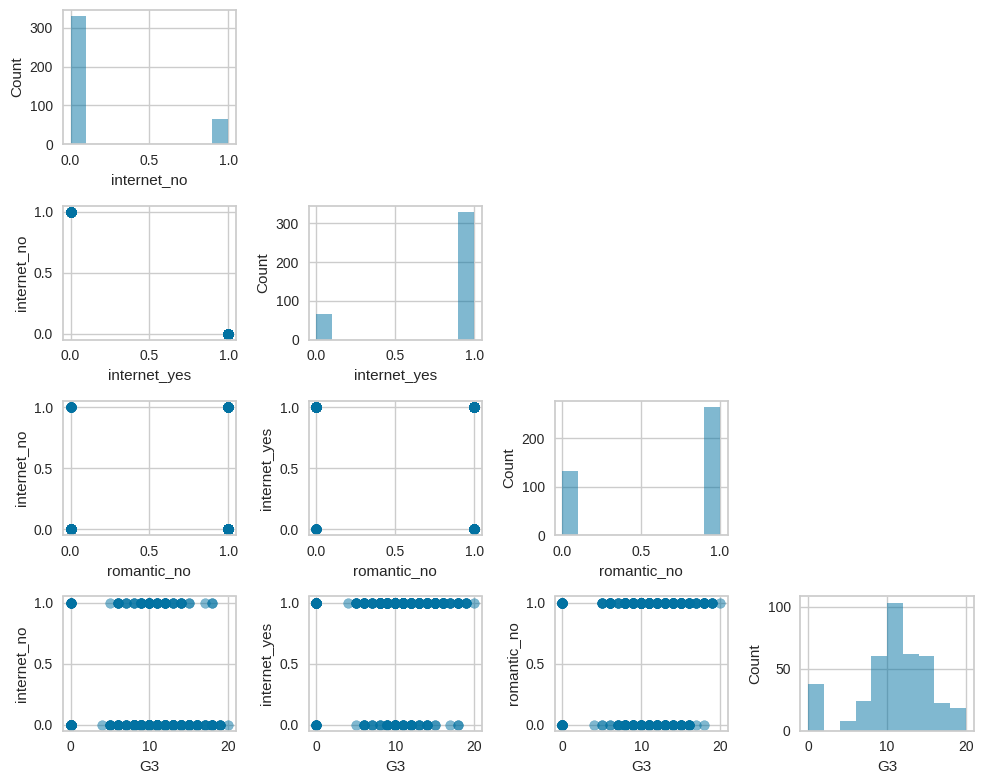

In [21]:
# Se explora la relación entre un conjunto específico de variables con la variable objetivo 'G3' por medio de gráficos de dispersión
for i in range(12):
  if i == 11:
    aux = columns[5*i:-1]
  else:
    aux = columns[5*i:5*(i+1)]
  aux = np.append(aux, 'G3')
  scatterplotmatrix(df_ohe[aux].values, figsize=(10, 8), names=df_ohe[aux].columns, alpha=0.5)
  plt.tight_layout()
  plt.show()

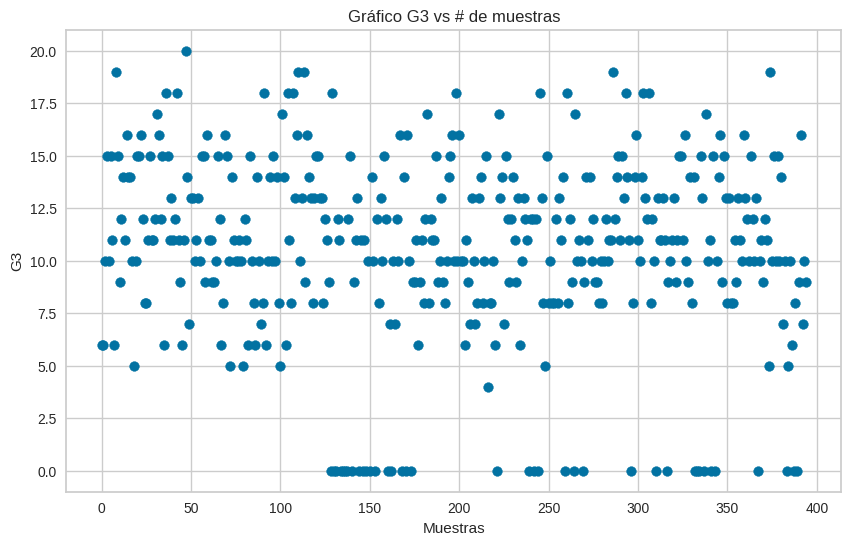

In [22]:
plt.figure(figsize=(10, 6))
plt.scatter(df_ohe.index, df_ohe['G3'], marker='o')
plt.title('Gráfico G3 vs # de muestras')
plt.xlabel('Muestras')
plt.ylabel('G3')
plt.grid(True)
plt.show()

De los gráficos anteriores, vemos una porcion de datos de G3 con valor en cero. Nos vamos a centrar en la distribución de datos diferentes de este valor.

In [23]:
df_ohe.drop(df_ohe[df_ohe['G3'] == 0].index, inplace=True)

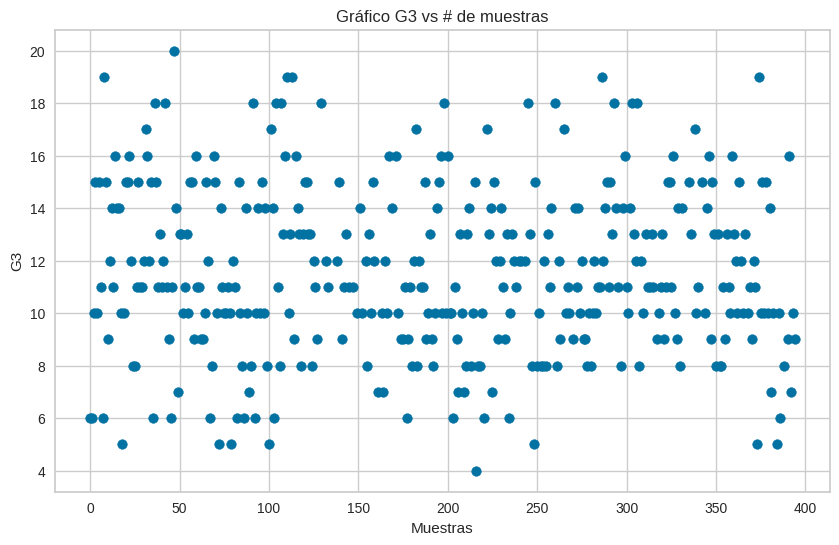

In [24]:
plt.figure(figsize=(10, 6))
plt.scatter(df_ohe.index, df_ohe['G3'], marker='o')
plt.title('Gráfico G3 vs # de muestras')
plt.xlabel('Muestras')
plt.ylabel('G3')
plt.grid(True)
plt.show()

Ahora vamos a graficar una matriz de correlaciones para las variables numéricas de este nuevo dataset

In [25]:
datos_numericos_filtered = datos_numericos.drop(datos_numericos[datos_numericos['G3'] == 0].index)

In [26]:
datos_numericos_filtered["G3"].value_counts()

10    56
11    47
15    33
8     32
13    31
12    31
9     28
14    27
16    16
6     15
18    12
7      9
5      7
17     6
19     5
20     1
4      1
Name: G3, dtype: int64

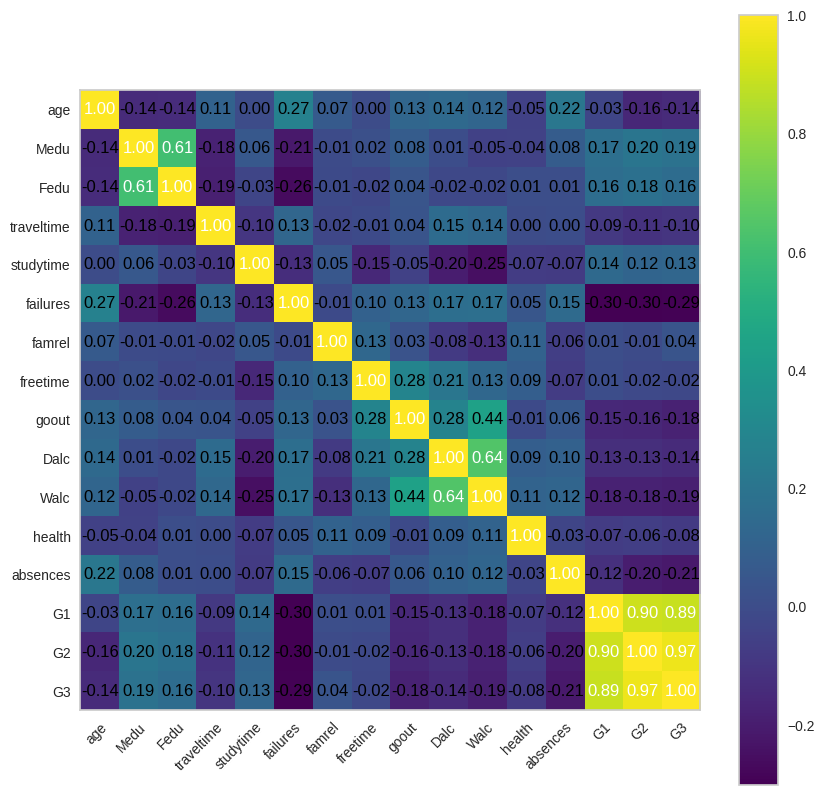

In [27]:
cm = np.corrcoef(datos_numericos_filtered.values.T)
hm = heatmap(cm, row_names=datos_numericos_filtered.columns,
             column_names=datos_numericos_filtered.columns,
             figsize=(10,10))
plt.show()

Observamos una alta correlación entre G3, G2 y G1. Vamos a eliminar G1 para bajar la redundancia. Existen otras variables con correlacion media, pero se van a dejar en el modelo para experimentar.

In [28]:
df_ohe.drop('G1', axis=1, inplace=True)
'G1' in df_ohe.columns

False

Los datos quedan listos para trabajar

# Entrenamiento de modelos

In [29]:
X = df_ohe.loc[:, df_ohe.columns != "G3"]
y = df_ohe['G3']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2)

In [30]:
X.shape

(357, 57)

## Modelo de regresión lineal múltiple

In [31]:
scaler = MinMaxScaler()
# Se crea una canalización con escalado y regresión lineal múltiple
pipe_lr = make_pipeline(scaler, LinearRegression())

# Crear un objeto KFold para la validación cruzada
cv_value = 2 # Valor para las validaciones cruzadas
kf = KFold(n_splits=cv_value)

# Realizar la validación cruzada y obtener los puntajes (scores)
scores = cross_val_score(pipe_lr, X_train, y_train, cv=kf, scoring='r2')

# Imprime el R^2 para cada pliegue
for i, score in enumerate(scores):
    print(f'Fold {i + 1} R^2 Score: {score:.4f}')

mean_score = scores.mean()
std_score = scores.std()

print(f'R^2 promedio: {mean_score:.4f}')
print(f'R^2 desviación estándar: {std_score:.4f}')

Fold 1 R^2 Score: 0.9150
Fold 2 R^2 Score: 0.9014
R^2 promedio: 0.9082
R^2 desviación estándar: 0.0068


In [32]:
# Se ajusta el modelo a los datos de entrenamiento
pipe_lr.fit(X_train, y_train)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('linearregression', LinearRegression())])

In [33]:
y_pred_train_lr = pipe_lr.predict(X_train)

print(f'R2: {r2_score(y_train, y_pred_train_lr):.4f}')
print(f'MAE: {mean_absolute_error(y_train, y_pred_train_lr):.4f}')
print(f'RMSE: {mean_squared_error(y_train, y_pred_train_lr):.4f}')

R2: 0.8818
MAE: 0.8967
RMSE: 1.2516


In [34]:
y_pred_test_lr = pipe_lr.predict(X_test)

print(f'R2: {r2_score(y_test, y_pred_test_lr):.4f}')
print(f'MAE: {mean_absolute_error(y_test, y_pred_test_lr):.4f}')
print(f'RMSE: {mean_squared_error(y_test, y_pred_test_lr):.4f}')

R2: 0.8040
MAE: 1.1542
RMSE: 1.8657


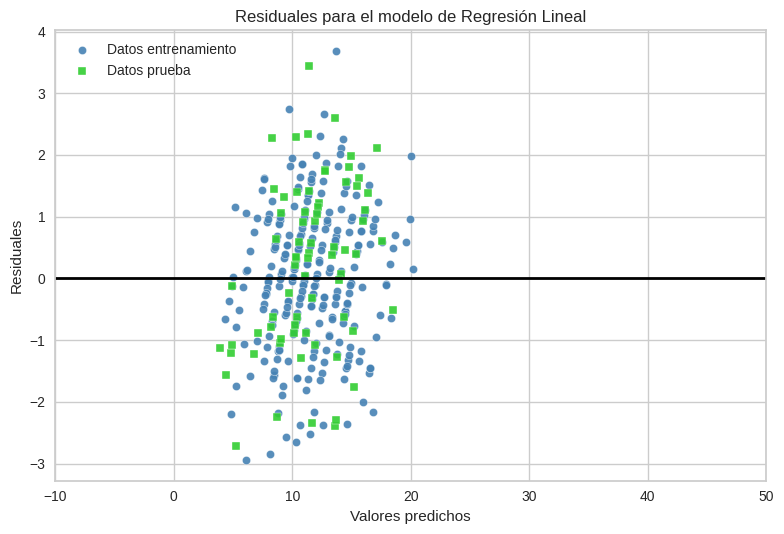

In [35]:
plot_residuals(y_pred_train_lr, y_train, y_pred_test_lr, y_test, "Residuales para el modelo de Regresión Lineal")

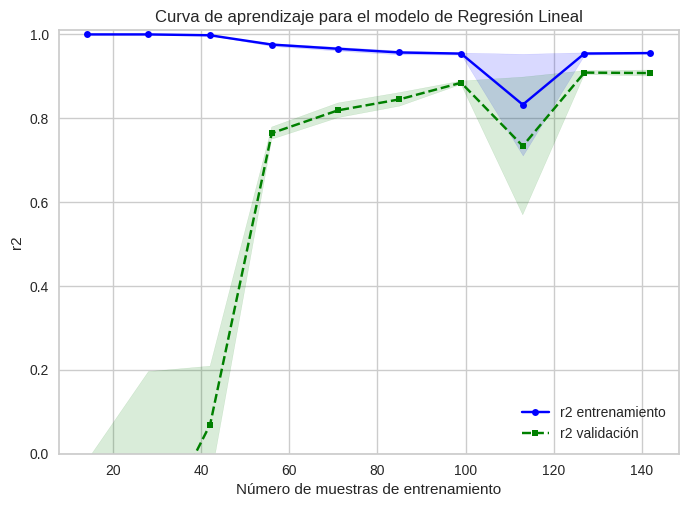

In [36]:
pipe_lr = make_pipeline(scaler, LinearRegression())
plot_learning_curve(pipe_lr, X_train, y_train, cv=cv_value, scoring="r2",
                    title="Curva de aprendizaje para el modelo de Regresión Lineal")

## Modelo de regresión con Random Forest Regression

In [37]:
# Se crea una canalización con escalado y modelo de Random Forest
scaler = MinMaxScaler()
rf = RandomForestRegressor(random_state=0)
pipe_rf = Pipeline([
    ('scaler', scaler),
    ('regressor', rf)
])

trees = [3,4,5,7,10,15]
criteria = ["squared_error","poisson"]
# Minimum number of samples required to split a node
min_samples_split = [5, 10, 15, 17, 19, 21,]
# Minimum number of samples required at each leaf node
min_samples_leaf = [3, 5, 7, 9, 12, 15, 20]
depths = [2,3]

param_grid = {
    'regressor__n_estimators': trees,  # RandomForestRegressor parameter
    'regressor__criterion': criteria,
    #'regressor__max_depth': depths,  # RandomForestRegressor parameter
    'regressor__min_samples_split': min_samples_split,
    'regressor__min_samples_leaf': min_samples_leaf
}

gs = GridSearchCV(estimator=pipe_rf,
                  param_grid=param_grid,
                  scoring='r2',
                  cv=cv_value,
                  refit=True,
                  n_jobs=-1,
                  verbose = 3,
                  return_train_score=True # set this for train score
                  )
gs = gs.fit(X_train, y_train)

print(gs.best_score_)
print(gs.best_params_)

Fitting 2 folds for each of 504 candidates, totalling 1008 fits
0.9173163929497933
{'regressor__criterion': 'poisson', 'regressor__min_samples_leaf': 3, 'regressor__min_samples_split': 10, 'regressor__n_estimators': 15}


In [38]:
y_pred_train_rf = gs.predict(X_train)

print(f'R2: {r2_score(y_train, y_pred_train_rf):.4f}')
print(f'MAE: {mean_absolute_error(y_train, y_pred_train_rf):.4f}')
print(f'RMSE: {mean_squared_error(y_train, y_pred_train_rf):.4f}')


R2: 0.9646
MAE: 0.4773
RMSE: 0.3744


In [39]:
y_pred_test_rf = gs.predict(X_test)

print(f'R2: {r2_score(y_test, y_pred_test_rf):.4f}')
print(f'MAE: {mean_absolute_error(y_test, y_pred_test_rf):.4f}')
print(f'RMSE: {mean_squared_error(y_test, y_pred_test_rf):.4f}')

R2: 0.9198
MAE: 0.6778
RMSE: 0.7636


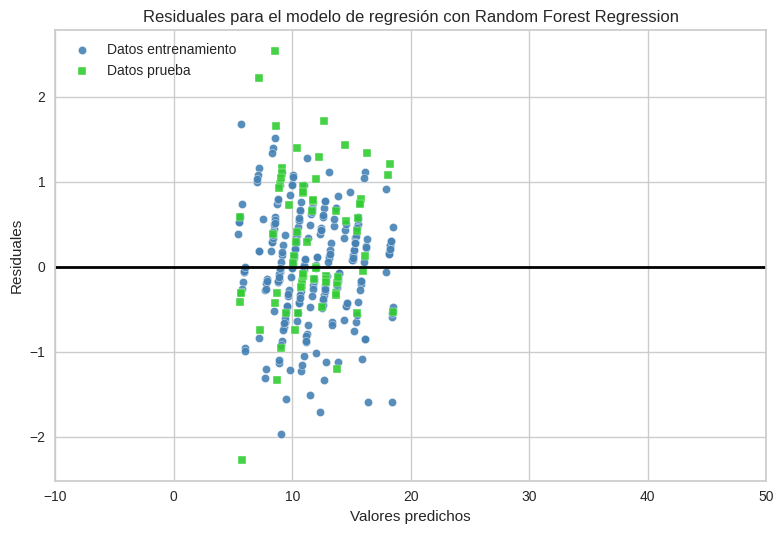

In [40]:
plot_residuals(y_pred_train_rf, y_train, y_pred_test_rf, y_test, "Residuales para el modelo de regresión con Random Forest Regression")

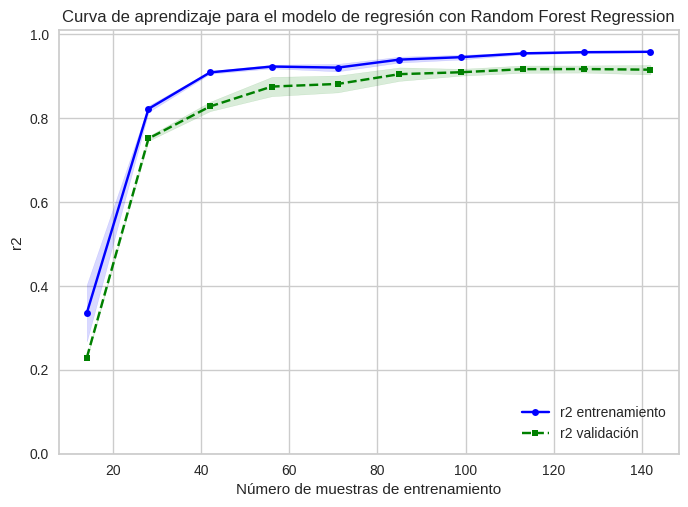

In [41]:
rf_regressor = gs.best_estimator_
plot_learning_curve(rf_regressor, X_train, y_train, cv=cv_value, scoring="r2",
                    title="Curva de aprendizaje para el modelo de regresión con Random Forest Regression")

## Modelo de regresión utilizando Support Vector Regression(SVR) con un kernel RBF

In [42]:
# Se crea una canalización con escalado y modelo de Support Vector Regression
scaler = MinMaxScaler()
svr = SVR(kernel = 'rbf')
pipe_svr = Pipeline([
    ('scaler', scaler),
    ('regressor', svr)
])

C = np.arange(7, 8, 0.001)

param_grid = {
    'regressor__C': C,
}

gs_svr = GridSearchCV(estimator=pipe_svr,
                  param_grid=param_grid,
                  scoring='r2',
                  cv=cv_value,
                  refit=True,
                  n_jobs=-1,
                  verbose = 3,
                  return_train_score=True # set this for train score
                  )
gs_svr = gs_svr.fit(X_train, y_train)

print(gs_svr.best_score_)
print(gs_svr.best_params_)

Fitting 2 folds for each of 1000 candidates, totalling 2000 fits
0.5771340342602582
{'regressor__C': 7.999000000000334}


In [43]:
y_pred_train_svr = gs_svr.predict(X_train)

print(f'R2: {r2_score(y_train, y_pred_train_svr):.4f}')
print(f'MAE: {mean_absolute_error(y_train, y_pred_train_svr):.4f}')
print(f'RMSE: {mean_squared_error(y_train, y_pred_train_svr):.4f}')

R2: 0.9909
MAE: 0.1759
RMSE: 0.0964


In [44]:
y_pred_test_svr = gs_svr.predict(X_test)

print(f'R2: {r2_score(y_test, y_pred_test_svr):.4f}')
print(f'MAE: {mean_absolute_error(y_test, y_pred_test_svr):.4f}')
print(f'RMSE: {mean_squared_error(y_test, y_pred_test_svr):.4f}')

R2: 0.7704
MAE: 1.1550
RMSE: 2.1864


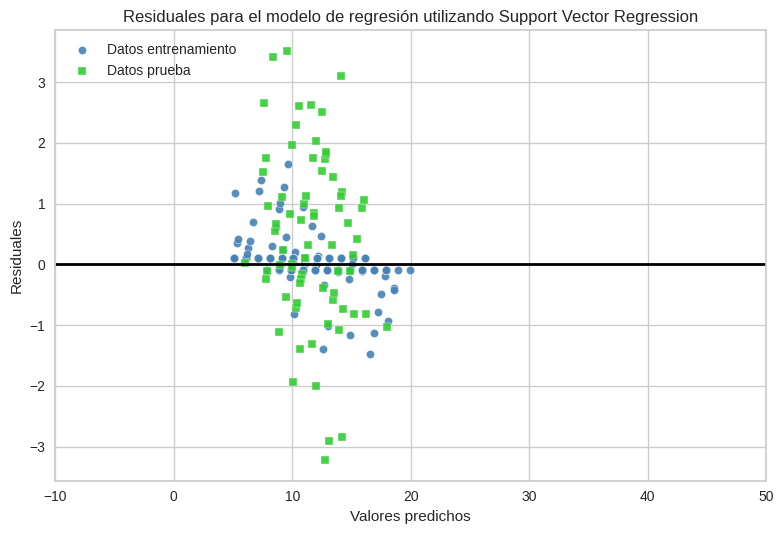

In [45]:
plot_residuals(y_pred_train_svr, y_train, y_pred_test_svr, y_test, "Residuales para el modelo de regresión utilizando Support Vector Regression")

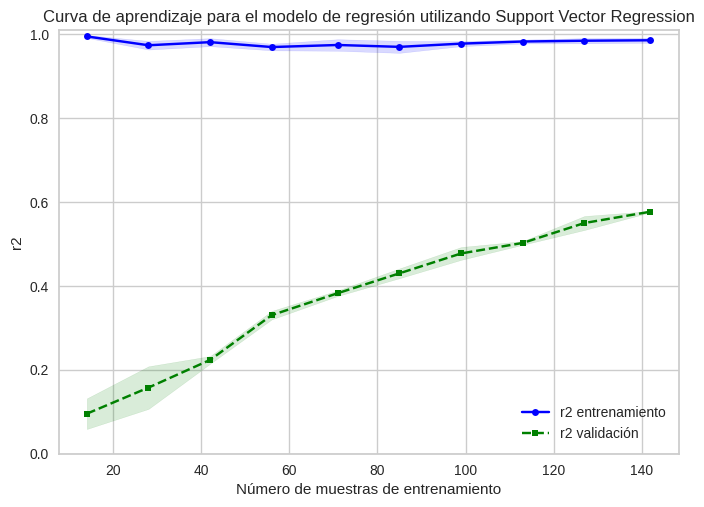

In [46]:
svr_regressor = gs_svr.best_estimator_
plot_learning_curve(svr_regressor, X_train, y_train, cv=cv_value, scoring="r2",
                    title="Curva de aprendizaje para el modelo de regresión utilizando Support Vector Regression")

## Modelo de regresión utilizando Redes Neuronales Artificiales(ANN)

In [47]:
def hidden_layers_list(neurons, hidden_layers):
  """
   Get all possible combinations of pairs of elements from two vectors.
   Parameters:
   - neurons: List, Neurons.
   - hidden_layers: List containing hidden layers.
   Returns:
   - List of tuples, each tuple representing a pair of elements from the two vectors.
   """
  combinations = []

  for neuron in neurons:
      for hl in hidden_layers:
          combinations.append(tuple([neuron]*hl))

  return combinations


In [48]:
X_train.shape

(285, 57)

In [49]:
ann = MLPRegressor(max_iter = 500, random_state=0)
steps = [
    ('scaler', MinMaxScaler()),
    ('regressor', ann)
]
pipe_mlp = Pipeline(steps)


neurons = [57, 60, 65, 70, 80, 100, 120, 130]
hidden_layer = [1,2,3,4, 5]
hidden_layers_param = hidden_layers_list(neurons, hidden_layer)


param_grid = {
    'regressor__hidden_layer_sizes': hidden_layers_param,
}

gs_mlp = GridSearchCV(
    estimator=pipe_mlp,
    param_grid=param_grid,
    cv=cv_value,
    scoring='r2',
    refit=True,
    n_jobs=-1,
    verbose = 3,
    return_train_score=True # set this for train score
)

gs_mlp.fit(X, y)

Fitting 2 folds for each of 40 candidates, totalling 80 fits


GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('regressor',
                                        MLPRegressor(max_iter=500,
                                                     random_state=0))]),
             n_jobs=-1,
             param_grid={'regressor__hidden_layer_sizes': [(57,), (57, 57),
                                                           (57, 57, 57),
                                                           (57, 57, 57, 57),
                                                           (57, 57, 57, 57, 57),
                                                           (60,), (60, 60),
                                                           (60, 60, 60),
                                                           (60, 60, 60, 60),
                                                           (60, 60, 60, 60, 60),
                                                           (65,), (65, 65),
                                                           (65, 65, 65),
                                                           (65, 65, 65, 65),
                                                           (65, 65, 65, 65, 65),
                                                           (70,), (70, 70),
                                                           (70, 70, 70),
                                                           (70, 70, 70, 70),
                                                           (70, 70, 70, 70, 70),
                                                           (80,), (80, 80),
                                                           (80, 80, 80),
                                                           (80, 80, 80, 80),
                                                           (80, 80, 80, 80, 80),
                                                           (100,), (100, 100),
                                                           (100, 100, 100),
                                                           (100, 100, 100, 100),
                                                           (100, 100, 100, 100,
                                                            100), ...]},
             return_train_score=True, scoring='r2', verbose=3)

In [50]:
print(gs_mlp.best_score_)
print(gs_mlp.best_params_)

0.7171018435403139
{'regressor__hidden_layer_sizes': (120, 120, 120, 120)}


In [51]:
y_pred_train_mlp = gs_mlp.predict(X_train)

print(f'R2: {r2_score(y_train, y_pred_train_mlp):.4f}')
print(f'MAE: {mean_absolute_error(y_train, y_pred_train_mlp):.4f}')
print(f'RMSE: {mean_squared_error(y_train, y_pred_train_mlp):.4f}')

R2: 0.9995
MAE: 0.0435
RMSE: 0.0049


In [52]:
y_pred_test_mlp = gs_mlp.predict(X_test)

print(f'R2: {r2_score(y_test, y_pred_test_mlp):.4f}')
print(f'MAE: {mean_absolute_error(y_test, y_pred_test_mlp):.4f}')
print(f'RMSE: {mean_squared_error(y_test, y_pred_test_mlp):.4f}')

R2: 0.9997
MAE: 0.0409
RMSE: 0.0030


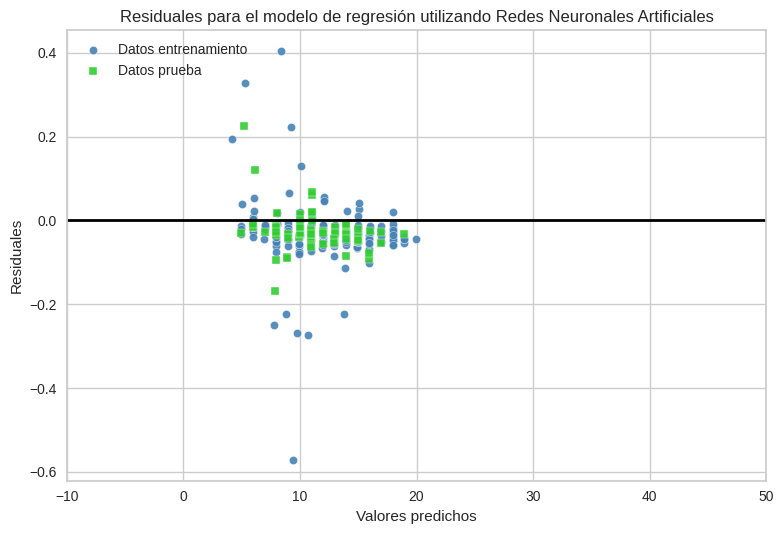

In [53]:
plot_residuals(y_pred_train_mlp, y_train, y_pred_test_mlp, y_test, "Residuales para el modelo de regresión utilizando Redes Neuronales Artificiales")

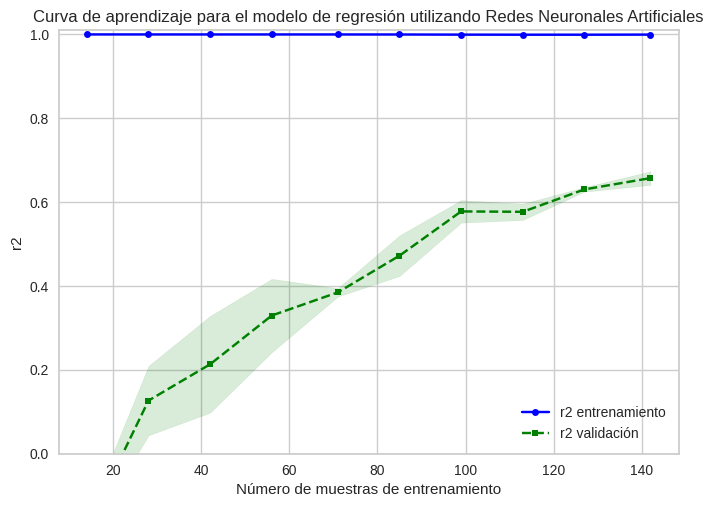

In [54]:
mlp_regressor = gs_mlp.best_estimator_
plot_learning_curve(mlp_regressor, X_train, y_train, cv=cv_value, scoring="r2",
                    title="Curva de aprendizaje para el modelo de regresión utilizando Redes Neuronales Artificiales")

## Técnica de aprendizaje automático AdaBoost Regressor

In [55]:
# Se crea una canalización con escalado y técnica AdaBoost
scaler = MinMaxScaler()
ada = AdaBoostRegressor(random_state=42)
pipe_ada = Pipeline([
    ('scaler', scaler),
    ('regressor', ada)
])

n_estimators = [3, 4, 5, 10, 60, 100]
learning_rate = np.arange(0.01, 1.01, 0.01)
loss = ["linear", "square", "exponential"]

param_grid = {

    'regressor__n_estimators': n_estimators,
    'regressor__learning_rate': learning_rate,
    'regressor__loss': loss
}

gs_ada = GridSearchCV(estimator=pipe_ada,
                  param_grid=param_grid,
                  scoring='r2',
                  cv=cv_value,
                  refit=True,
                  n_jobs=-1,
                  verbose = 3,
                  return_train_score=True
                  )
gs_ada = gs_ada.fit(X_train, y_train)

print(gs_ada.best_score_)
print(gs_ada.best_params_)

Fitting 2 folds for each of 1800 candidates, totalling 3600 fits
0.9231237845644391
{'regressor__learning_rate': 0.66, 'regressor__loss': 'exponential', 'regressor__n_estimators': 10}


In [56]:
y_pred_train_ada = gs_ada.predict(X_train)

print(f'R2: {r2_score(y_train, y_pred_train_ada):.4f}')
print(f'MAE: {mean_absolute_error(y_train, y_pred_train_ada):.4f}')
print(f'RMSE: {mean_squared_error(y_train, y_pred_train_ada):.4f}')

R2: 0.9351
MAE: 0.6836
RMSE: 0.6869


In [57]:
y_pred_test_ada = gs_ada.predict(X_test)

print(f'R2: {r2_score(y_test, y_pred_test_ada):.4f}')
print(f'MAE: {mean_absolute_error(y_test, y_pred_test_ada):.4f}')
print(f'RMSE: {mean_squared_error(y_test, y_pred_test_ada):.4f}')

R2: 0.9046
MAE: 0.7382
RMSE: 0.9081


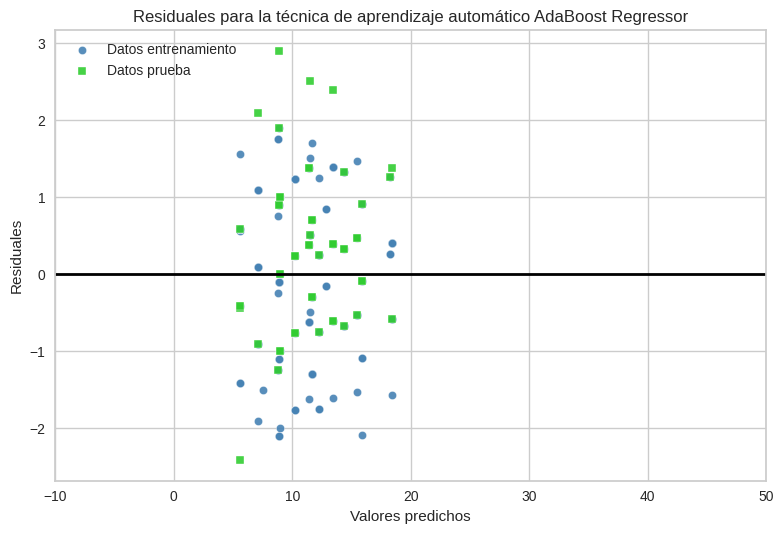

In [58]:
plot_residuals(y_pred_train_ada, y_train, y_pred_test_ada, y_test, "Residuales para la técnica de aprendizaje automático AdaBoost Regressor")

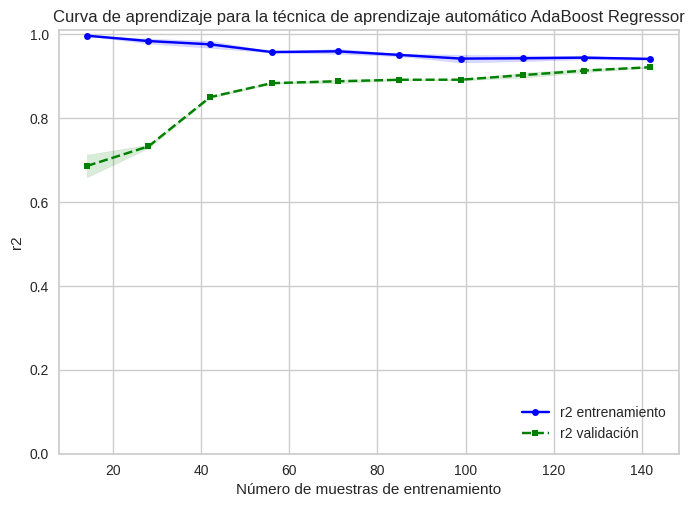

In [59]:
ada_regressor = gs_ada.best_estimator_
plot_learning_curve(ada_regressor, X_train, y_train, cv=cv_value, scoring="r2",
                    title="Curva de aprendizaje para la técnica de aprendizaje automático AdaBoost Regressor")